In [1]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from aux_funcs import colored_line
# from aux_funcs import parse_string_with_regex, ordered_colors_from_cmap

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2.0

In [2]:
def load_hidden_activity(data_path, averaging_size=1):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=1)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

def load_state_data(data_path, indices=[]):
#     file_names = glob.glob(data_path)
    file_names = sorted(os.listdir(data_path))
    print(file_names)
    for fidx, file_name in enumerate(file_names):
        if fidx in indices or (len(indices) == 0 and fidx + 1 == len(file_names)):
            data_for_file = pickle.load(open(os.path.join(data_path, file_name), 'rb'))
            yield data_for_file

In [3]:
def parse_session(data_path, env_idx, update_num=None):
    indices = [] if update_num is None else [update_num]
    state_data = load_state_data(
        data_path,
        indices=indices,
    )
    
    d = state_data.__next__()

    features = [
        'current_patch_num',
        'reward_site_idx',
        'current_reward_site_attempted',
        'agent_in_patch',
        'patch_reward_param',
        'action',
        'reward',
    ]

    features_to_time_series_dict = {}
    for f in features:
        features_to_time_series_dict[f] = np.zeros((len(d)))
    
    for k in np.arange(len(d)):
        for f in features:
            features_to_time_series_dict[f][k] = d[k][f][env_idx]

    dwell_time = np.zeros((len(d)))
    for idx in np.arange(1, len(d)):
        if features_to_time_series_dict['action'][idx] == 0:
            dwell_time[idx] = dwell_time[idx-1] + 1
        else:
            dwell_time[idx] = 0
    features_to_time_series_dict['dwell_time'] = dwell_time
    
    return features_to_time_series_dict

['00000.pkl']
(5000, 20, 128)
0.9767529876020479
0.9251446825244397


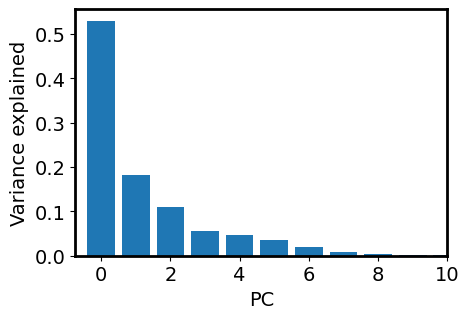

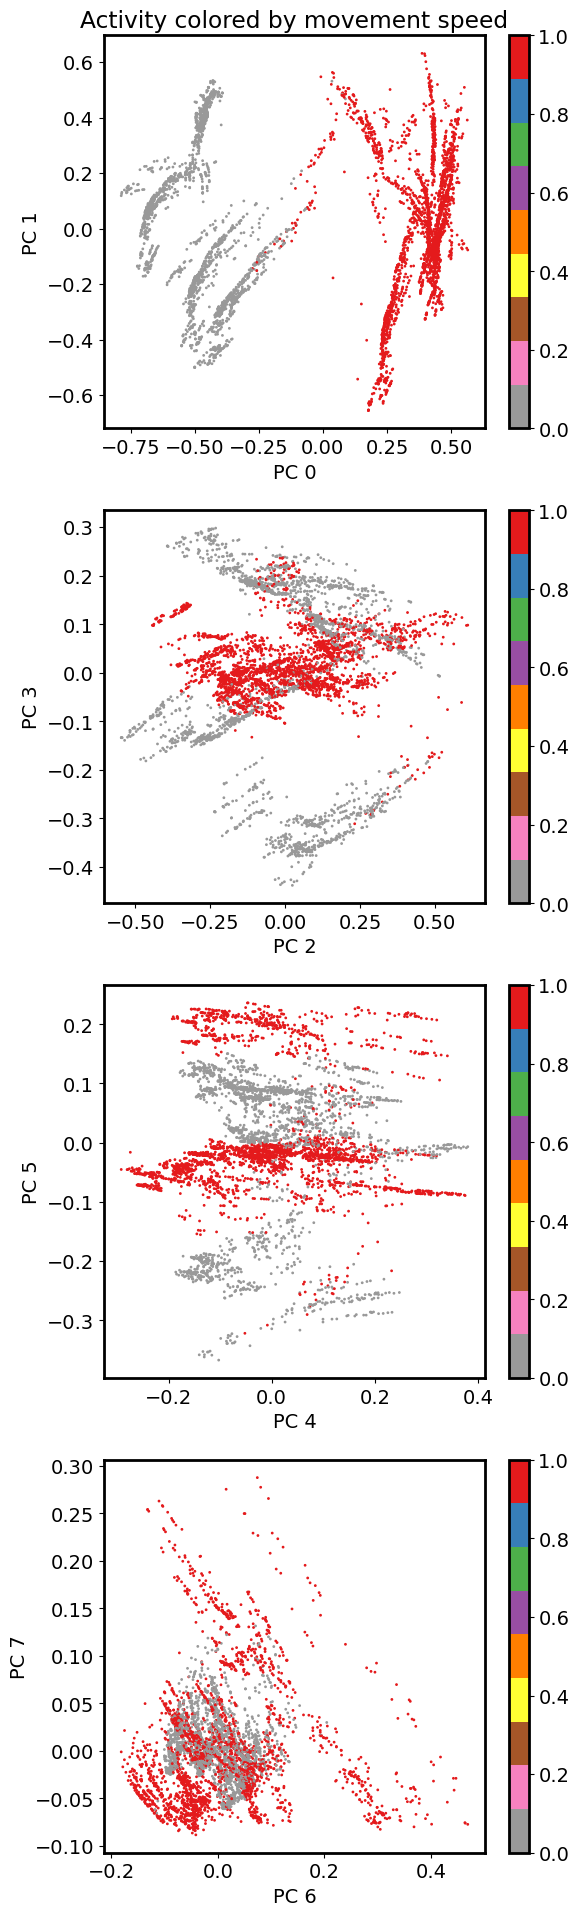

In [4]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', 0)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1],
        s=1,
        c=session_data['action'],
        cmap='Set1_r',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Activity colored by movement speed')

pcs = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), :2]

reg = LinearRegression().fit(data[:2500, 0, :], session_data['action'][:2500])
print(reg.score(data[2500:, 0, :], session_data['action'][2500:]))

reg = LinearRegression().fit(pcs[:2500, :], session_data['action'][:2500])
print(reg.score(pcs[2500:, :], session_data['action'][2500:]))

    

['00000.pkl']
(5000, 20, 128)


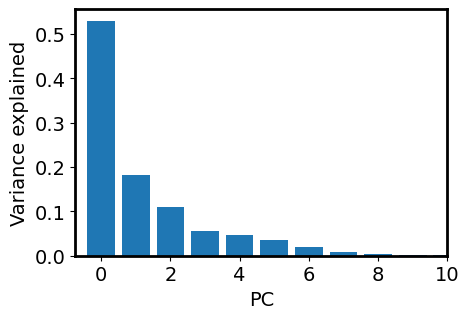

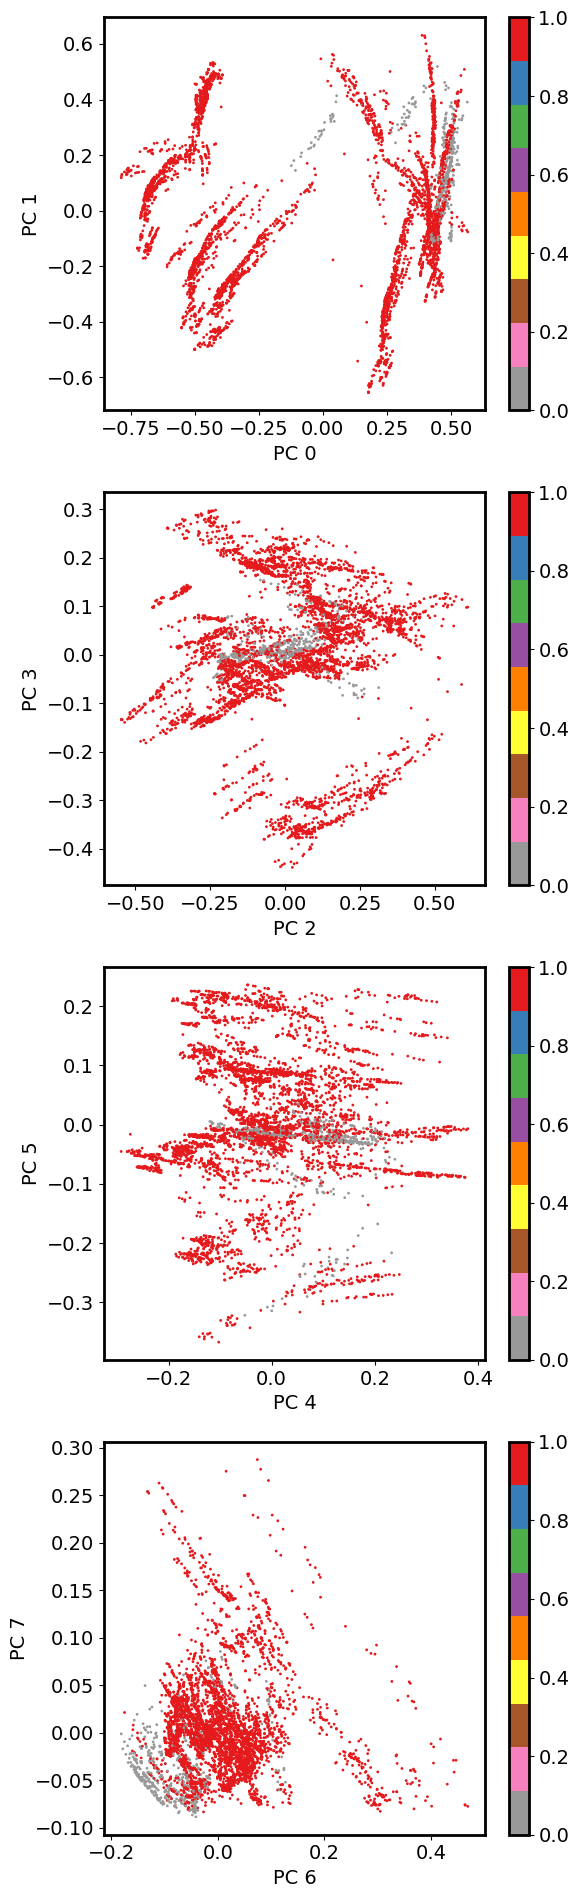

In [175]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1],
        s=1,
        c=session_data['agent_in_patch'],
        cmap='Set1_r',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

['00000.pkl']
(5000, 20, 128)


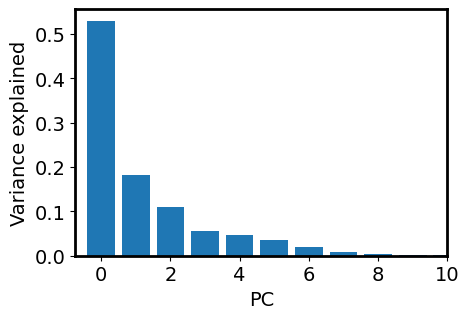

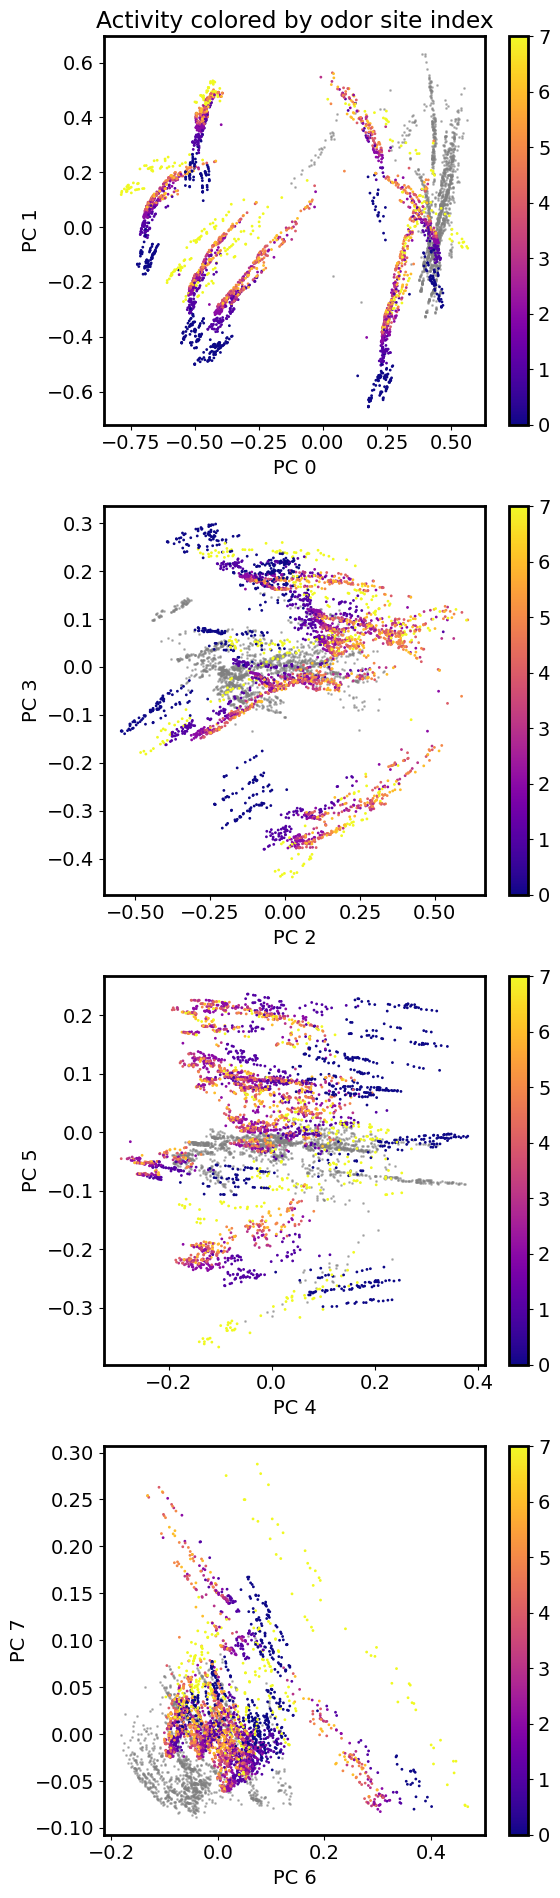

In [176]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', 0)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['reward_site_idx'] < 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['reward_site_idx'] < 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['reward_site_idx'] >= 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['reward_site_idx'] >= 0],
        s=1,
        c=session_data['reward_site_idx'][session_data['reward_site_idx'] >= 0],
        cmap='plasma',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)

axs[0].set_title('Activity colored by odor site index')
fig.tight_layout()

['00000.pkl']
(5000, 20, 128)


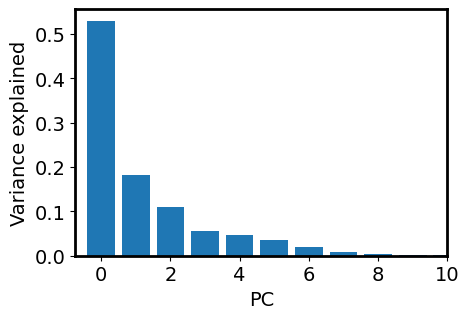

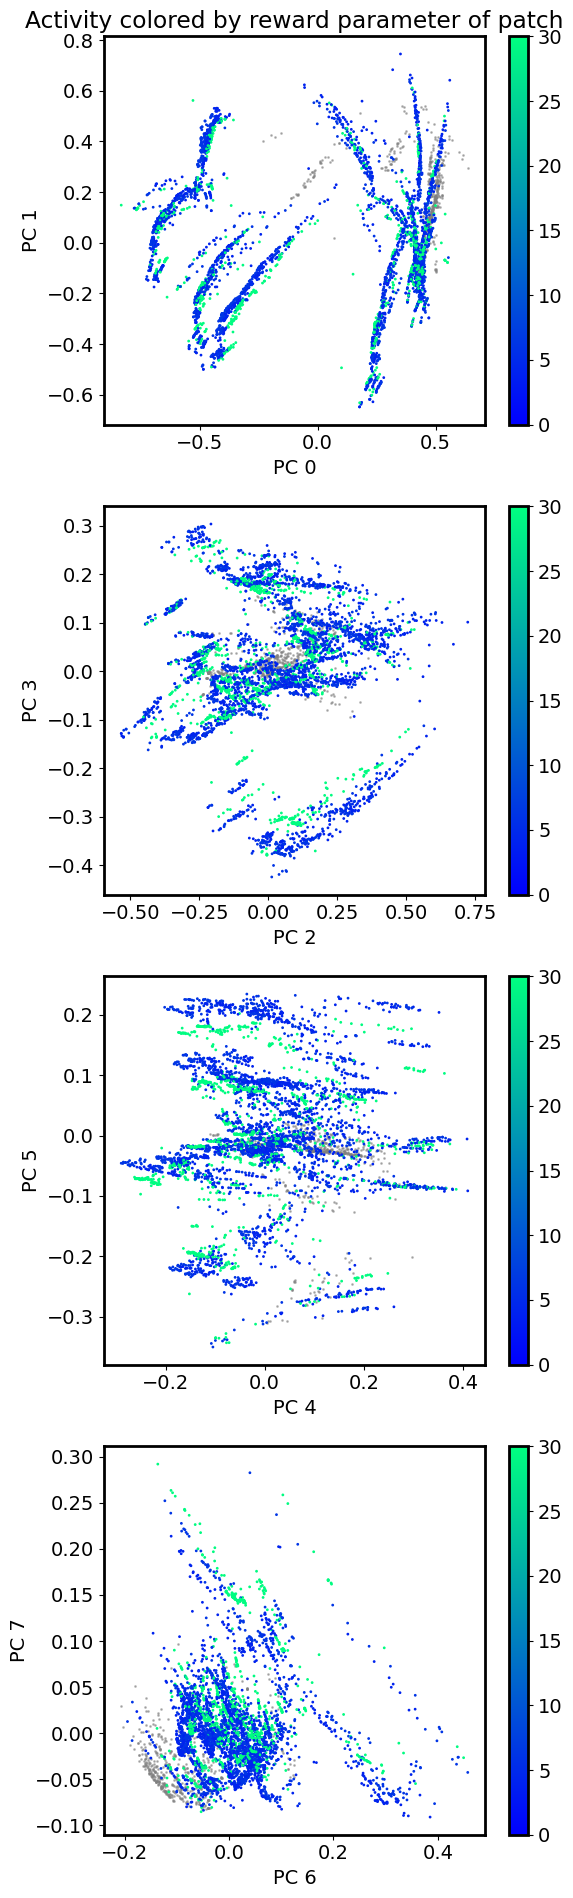

In [177]:
env_idx = 9

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['agent_in_patch'] <= 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['agent_in_patch'] > 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['patch_reward_param'][session_data['agent_in_patch'] > 0],
        cmap='winter',
        vmin=0,
        vmax=30,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
axs[0].set_title('Activity colored by reward parameter of patch')
fig.tight_layout()


['00000.pkl']
(5000, 20, 128)


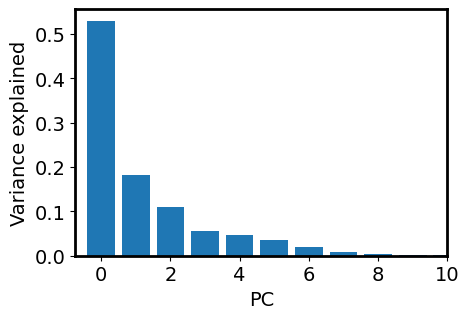

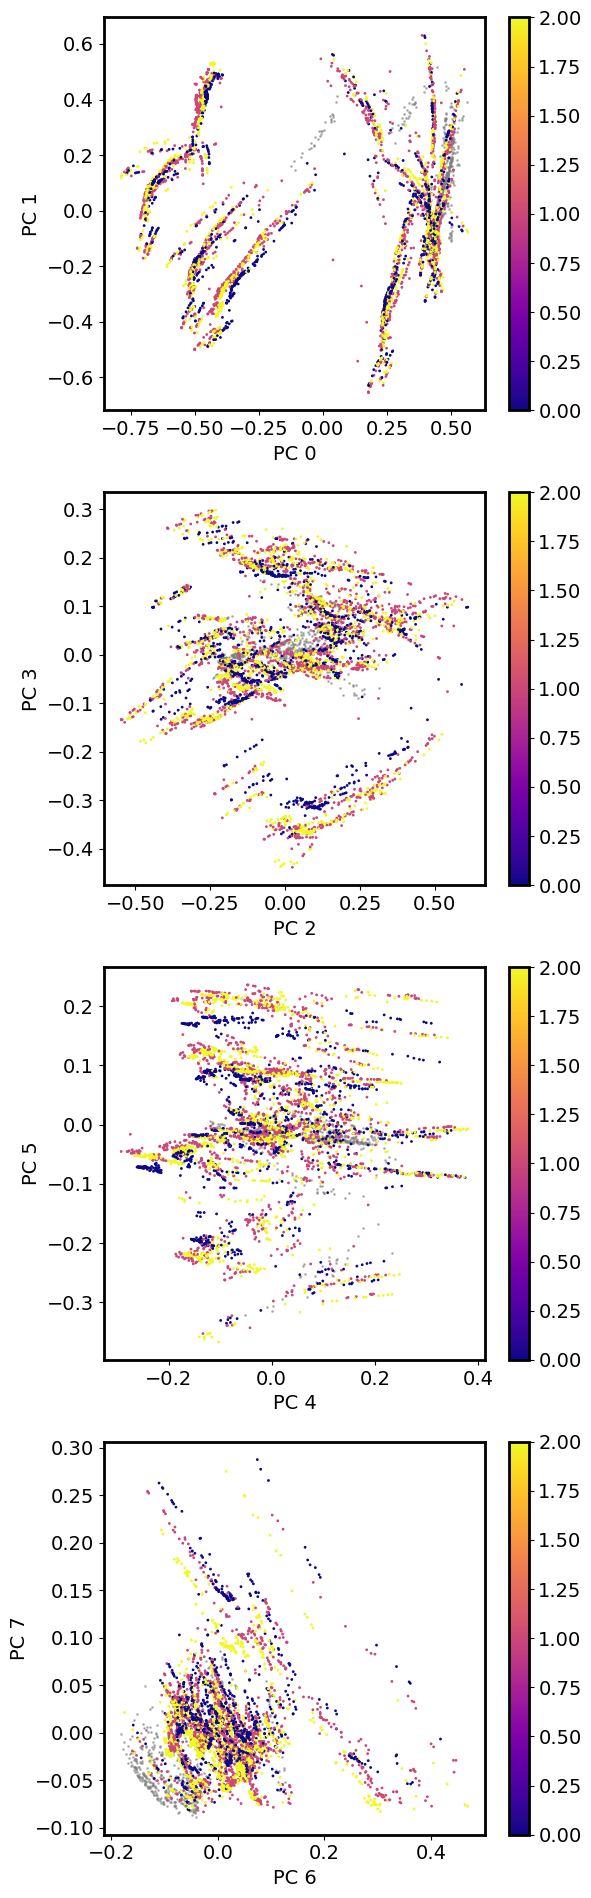

In [178]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', 0)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['agent_in_patch'] <= 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][session_data['agent_in_patch'] > 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['current_patch_num'][session_data['agent_in_patch'] > 0],
        cmap='plasma',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()


['00000.pkl']
(5000, 20, 128)


Text(0.5, 1.0, 'Activity colored by reward')

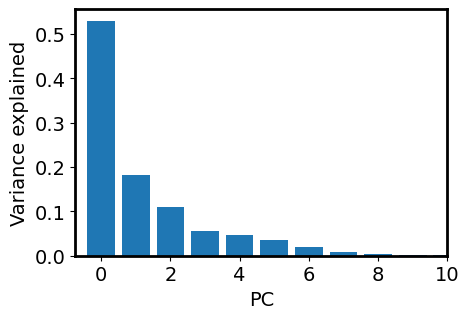

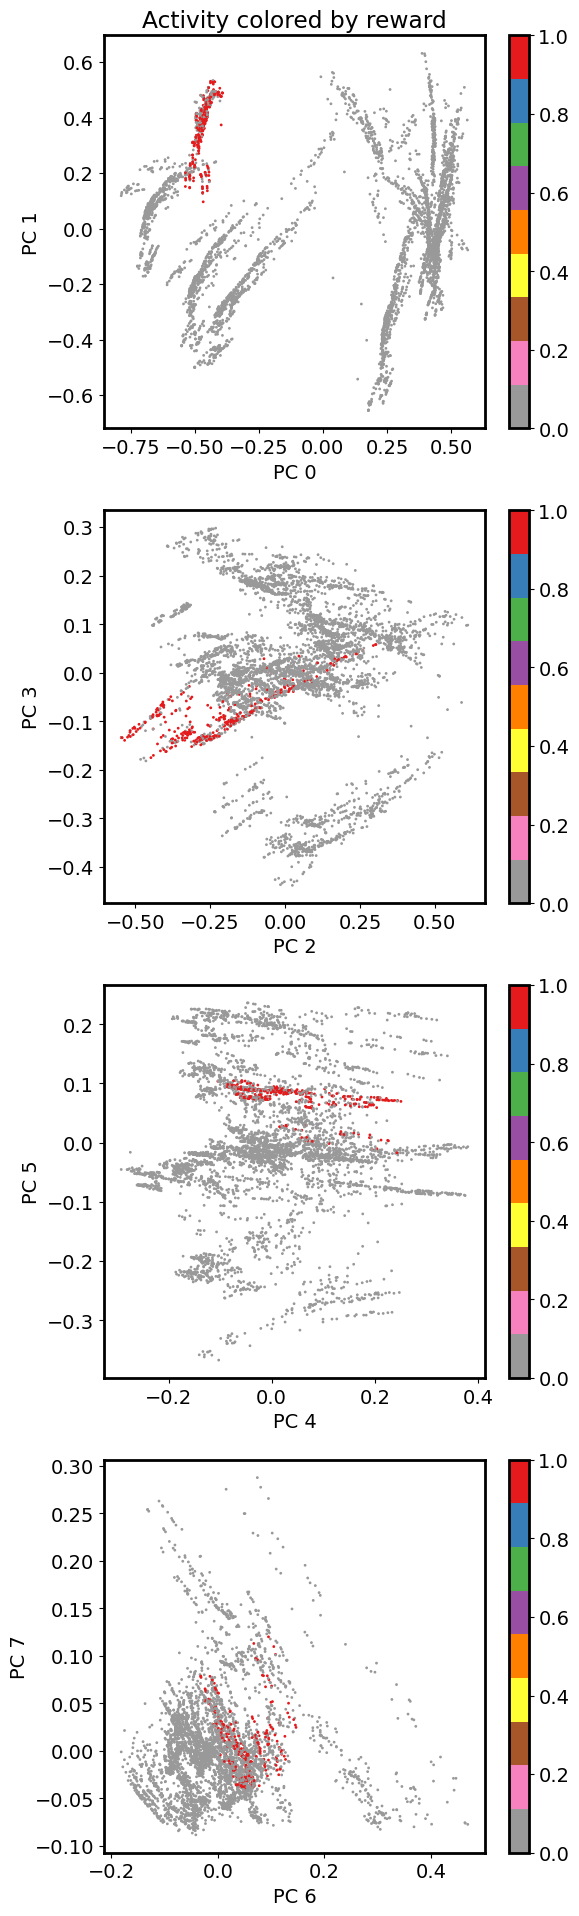

In [179]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', 0)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1],
        s=1,
        c=session_data['reward'],
        cmap='Set1_r',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Activity colored by reward')


In [122]:
def masks_to_colors(masks):
    c = np.zeros(masks[0].shape)
    for mask_idx, mask in enumerate(masks):
        c[mask] = mask_idx + 1
    return c

['00000.pkl']
(5000, 20, 128)


Text(0.5, 1.0, 'Steps since reward observed')

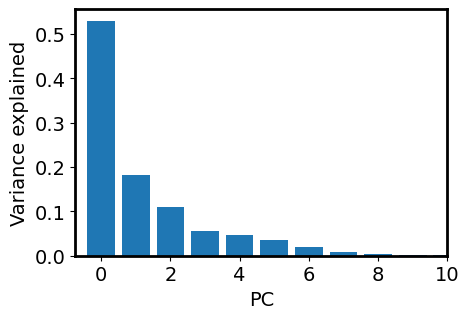

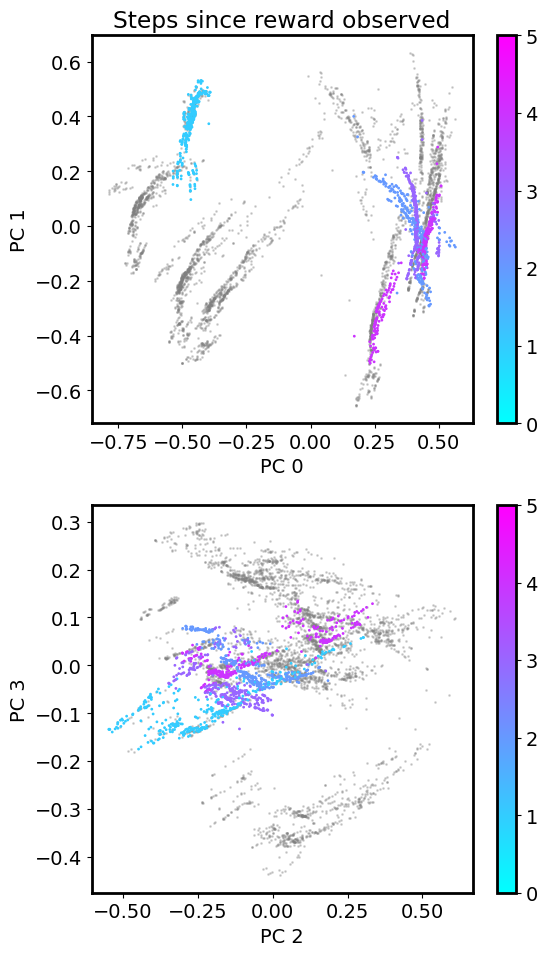

In [151]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

num_pcs = 4

scale = 1.2
fig, axs = plt.subplots(int(num_pcs / 2), 1, figsize=(5 * scale, 2 * num_pcs * scale))

masks = [np.logical_and(np.roll(session_data['reward'], i).astype(bool), np.roll(session_data['dwell_time'], i) == 4) for i in range(0, 4)]
c = masks_to_colors(masks)

for k in np.arange(0, num_pcs, 2):
    axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][c == 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][c == 0],
        s=1,
        color='grey',
        alpha=0.3,
        # vmax=2,
    )
    
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][c > 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][c > 0],
        s=1,
        c=c[c > 0],
        cmap='cool',
        vmin=0,
        vmax=c.max() + 1,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Steps since reward observed')


['00000.pkl']
(5000, 20, 128)


Text(0.5, 1.0, 'Steps since reward missed')

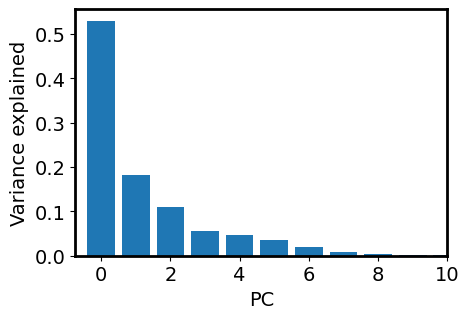

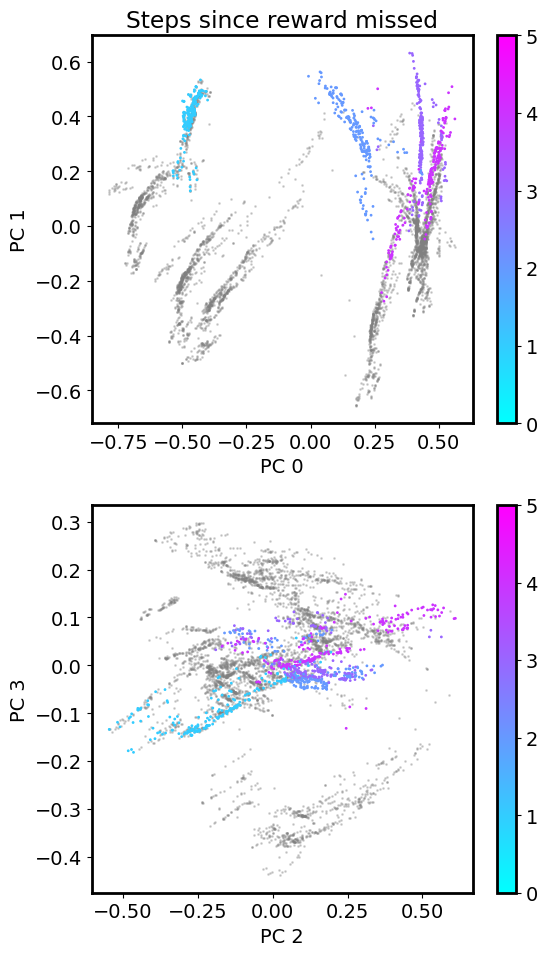

In [152]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

num_pcs = 4

scale = 1.2
fig, axs = plt.subplots(int(num_pcs / 2), 1, figsize=(5 * scale, 2 * num_pcs * scale))

masks = [np.logical_and(~(np.roll(session_data['reward'], i).astype(bool)), np.roll(session_data['dwell_time'], i) == 4) for i in range(0, 4)]
c = masks_to_colors(masks)

for k in np.arange(0, num_pcs, 2):
    axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][c == 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][c == 0],
        s=1,
        color='grey',
        alpha=0.3,
        # vmax=2,
    )
    
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k][c > 0],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1][c > 0],
        s=1,
        c=c[c > 0],
        cmap='cool',
        vmin=0,
        vmax=c.max() + 1,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)

    
fig.tight_layout()

axs[0].set_title('Steps since reward missed')

['00000.pkl']
(5000, 20, 128)


Text(0.5, 1.0, 'Activity colored by dwell time')

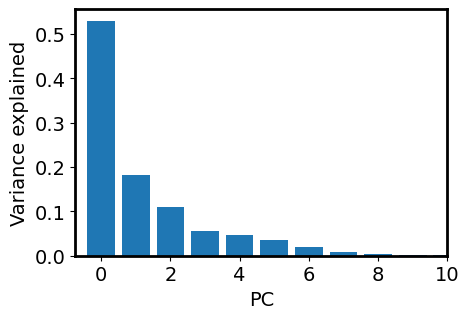

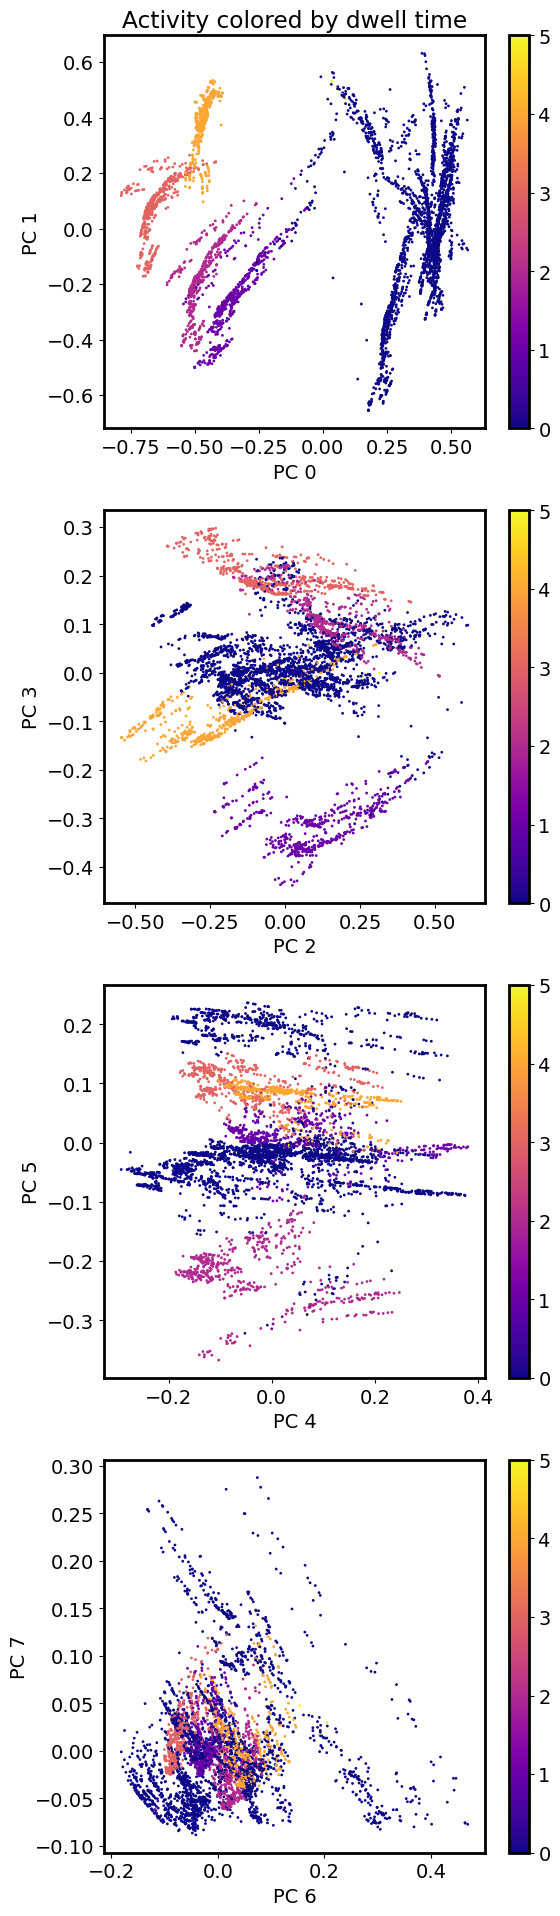

In [188]:
env_idx = 0

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')

session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', 0)
print(data.shape)
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))


for k in np.arange(0, 8, 2):
    cbar = axs[int(k/2)].scatter(
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k],
        pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1],
        s=1,
        c=session_data['dwell_time'],
        cmap='plasma',
        # vmax=2,
    )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Activity colored by dwell time')

In [5]:
def find_patch_trajectories(agent_in_patch_ts):
    starts_and_stops = []
    start_idx = None
    for k in np.arange(len(agent_in_patch_ts)):
        if agent_in_patch_ts[k] > 0:
            if start_idx is None:
                start_idx = k
        elif (k > 0 and agent_in_patch_ts[k-1] > 0 and start_idx is not None):
            starts_and_stops.append(slice(start_idx, k))
            start_idx = None
    return starts_and_stops

['00000.pkl']


Text(0.5, 1.0, 'Within-patch state space trajectories')

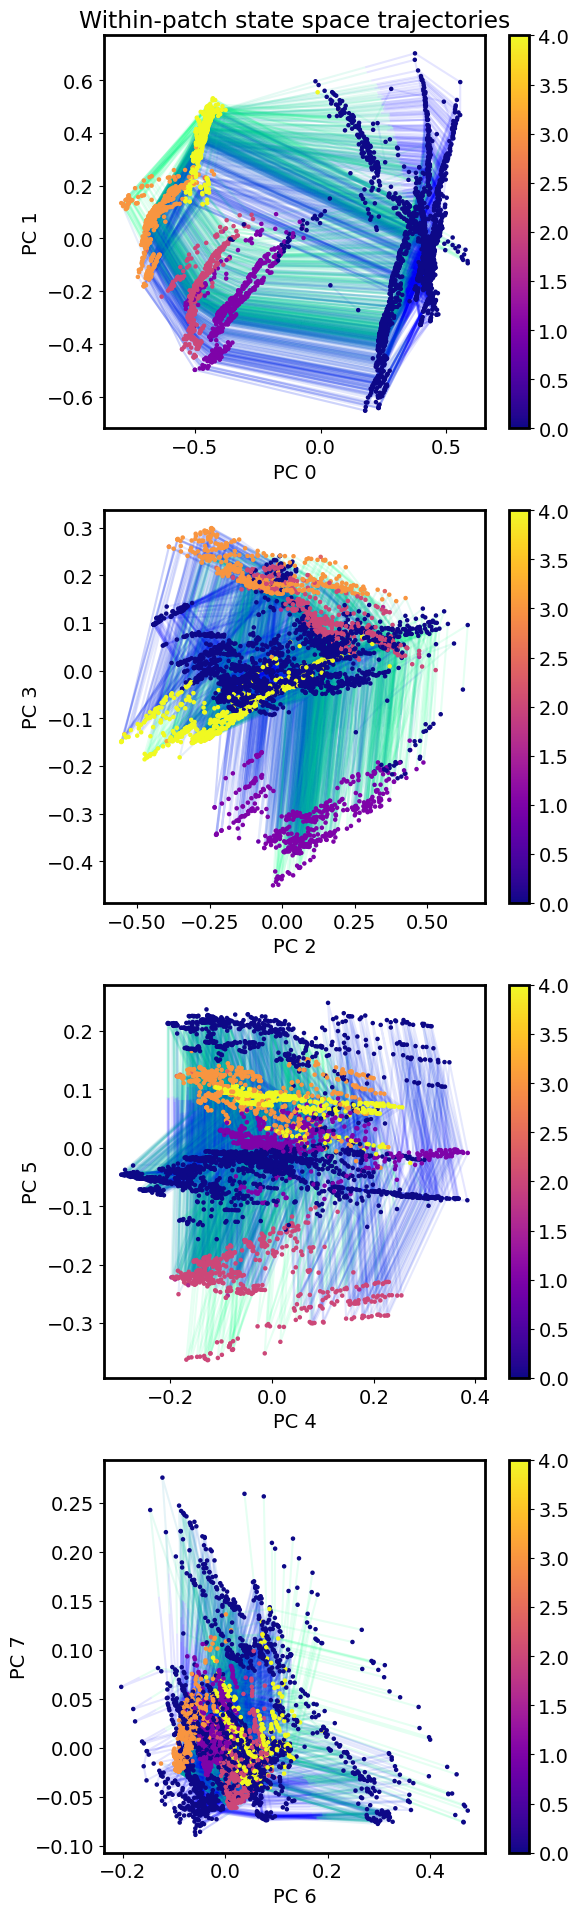

In [72]:
env_idx = 1

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')
session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])

for k in np.arange(0, 8, 2):
    pc_a = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k]
    pc_b = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1]

    # cbar = axs[int(k/2)].scatter(
    #     pc_a,
    #     pc_b,
    #     s=1,
    #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
    #     # vmax=2,
    #     alpha=0.2
    # )
    
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        if traj_idx > -1:
            # axs[int(k/2)].plot(
            #     pc_a[patch_traj_indices],
            #     pc_b[patch_traj_indices],
            #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            #     # vmax=2,
            #     # c=session_data['patch_reward_param'][patch_traj_indices][0],
            #     # cmap='plasma',
            #     color='black',
            #     alpha=0.2,
            # )
            colored_line(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                session_data['reward_site_idx'][patch_traj_indices],
                axs[int(k/2)],
                alpha=0.1,
                cmap='winter',
                zorder=-1,
            )
    
            cbar = axs[int(k/2)].scatter(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                c=session_data['dwell_time'][patch_traj_indices],
                cmap='plasma',
                s=5,
            )
        else:
            axs[int(k/2)].scatter(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                c=session_data['dwell_time'][patch_traj_indices],
                cmap='plasma',
                s=5,
                alpha=0.05,
            )
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Within-patch state space trajectories')

['00000.pkl']


Text(0.5, 1.0, 'Within-patch state space trajectories')

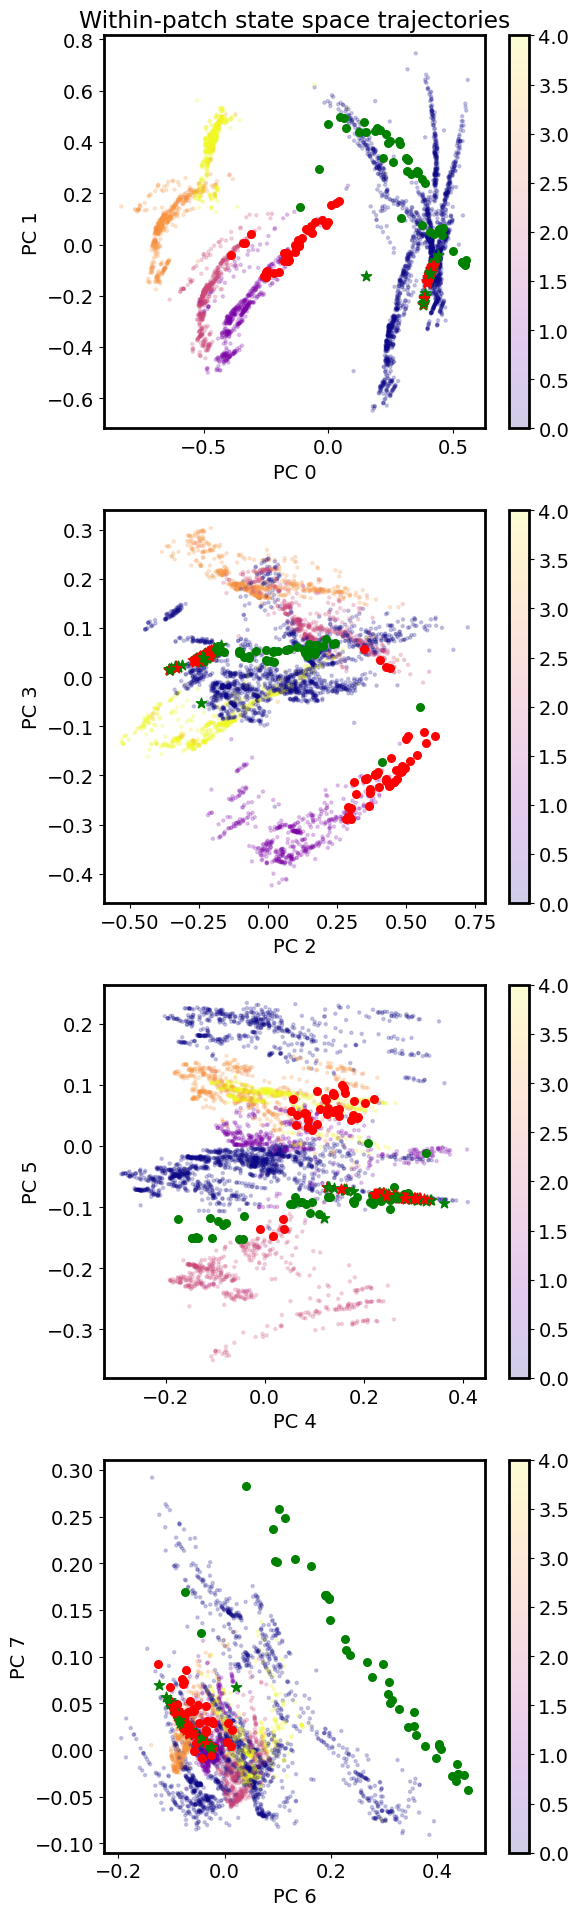

In [57]:
env_idx = 9

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')
session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])

for k in np.arange(0, 8, 2):
    pc_a = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k]
    pc_b = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1]

    # cbar = axs[int(k/2)].scatter(
    #     pc_a,
    #     pc_b,
    #     s=1,
    #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
    #     # vmax=2,
    #     alpha=0.2
    # )
    
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        c = session_data['reward_site_idx'][patch_traj_indices].max() * np.ones(len(pc_b[patch_traj_indices]))

        if session_data['reward_site_idx'][patch_traj_indices].max() == 7:
            c = 'green'
        else:
            c = 'red'
        
        # axs[int(k/2)].plot(
        #     pc_a[patch_traj_indices],
        #     pc_b[patch_traj_indices],
        #     alpha=0.1,
        #     color=c,
        #     zorder=-2,
        # )

        cbar = axs[int(k/2)].scatter(
            pc_a[patch_traj_indices],
            pc_b[patch_traj_indices],
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            c=session_data['dwell_time'][patch_traj_indices],
            cmap='plasma',
            s=5,
            zorder=-1,
            alpha=0.2,
        )

        axs[int(k/2)].scatter(
            pc_a[patch_traj_indices][0],
            pc_b[patch_traj_indices][0],
            marker='*',
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            color=c,
            s=60,
        )

        axs[int(k/2)].scatter(
            pc_a[patch_traj_indices][-1],
            pc_b[patch_traj_indices][-1],
            marker='o',
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            color=c,
            s=30,
        )
            
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Within-patch state space trajectories')

['00000.pkl']


Text(0.5, 1.0, 'Within-patch state space trajectories')

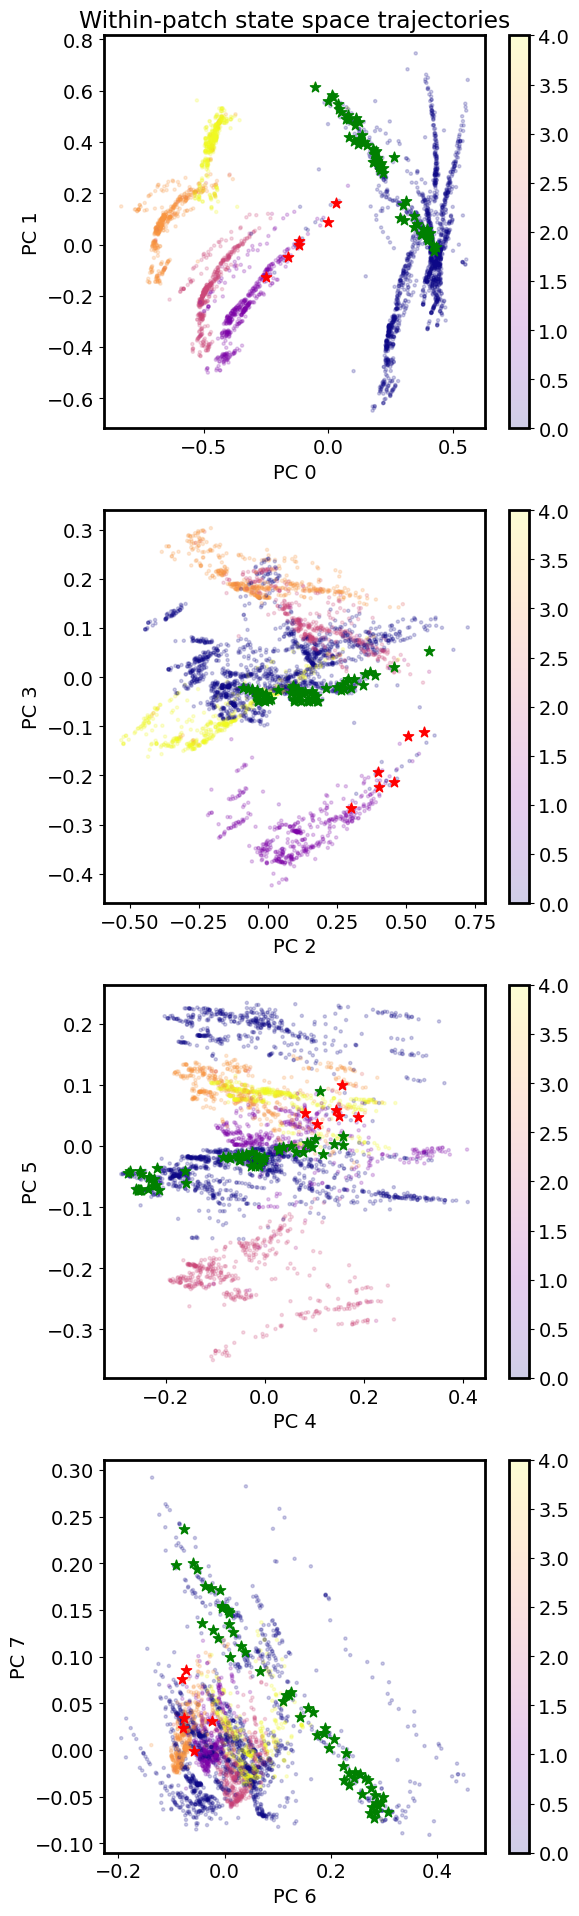

In [71]:
env_idx = 9

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')
session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])

exit_step = 5

for k in np.arange(0, 8, 2):
    pc_a = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k]
    pc_b = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1]

    # cbar = axs[int(k/2)].scatter(
    #     pc_a,
    #     pc_b,
    #     s=1,
    #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
    #     # vmax=2,
    #     alpha=0.2
    # )
    
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        c = session_data['reward_site_idx'][patch_traj_indices].max() * np.ones(len(pc_b[patch_traj_indices]))

        if session_data['reward_site_idx'][patch_traj_indices].max() >= exit_step:
            if session_data['reward_site_idx'][patch_traj_indices].max() == exit_step:
                c = 'red'
            else:
                c = 'green'
            
            # axs[int(k/2)].plot(
            #     pc_a[patch_traj_indices],
            #     pc_b[patch_traj_indices],
            #     alpha=0.1,
            #     color=c,
            #     zorder=-2,
            # )
    
            cbar = axs[int(k/2)].scatter(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                c=session_data['dwell_time'][patch_traj_indices],
                cmap='plasma',
                s=5,
                zorder=-1,
                alpha=0.2,
            )
    
            axs[int(k/2)].scatter(
                pc_a[patch_traj_indices][session_data['reward_site_idx'][patch_traj_indices] == exit_step][-1],
                pc_b[patch_traj_indices][session_data['reward_site_idx'][patch_traj_indices] == exit_step][-1],
                marker='*',
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                color=c,
                s=60,
            )

        # axs[int(k/2)].scatter(
        #     pc_a[patch_traj_indices][0],
        #     pc_b[patch_traj_indices][0],
        #     marker='o',
        #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
        #     # vmax=2,
        #     color=c,
        #     s=30,
        # )
            
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Within-patch state space trajectories')

['00000.pkl']


Text(0.5, 1.0, 'Within-patch state space trajectories')

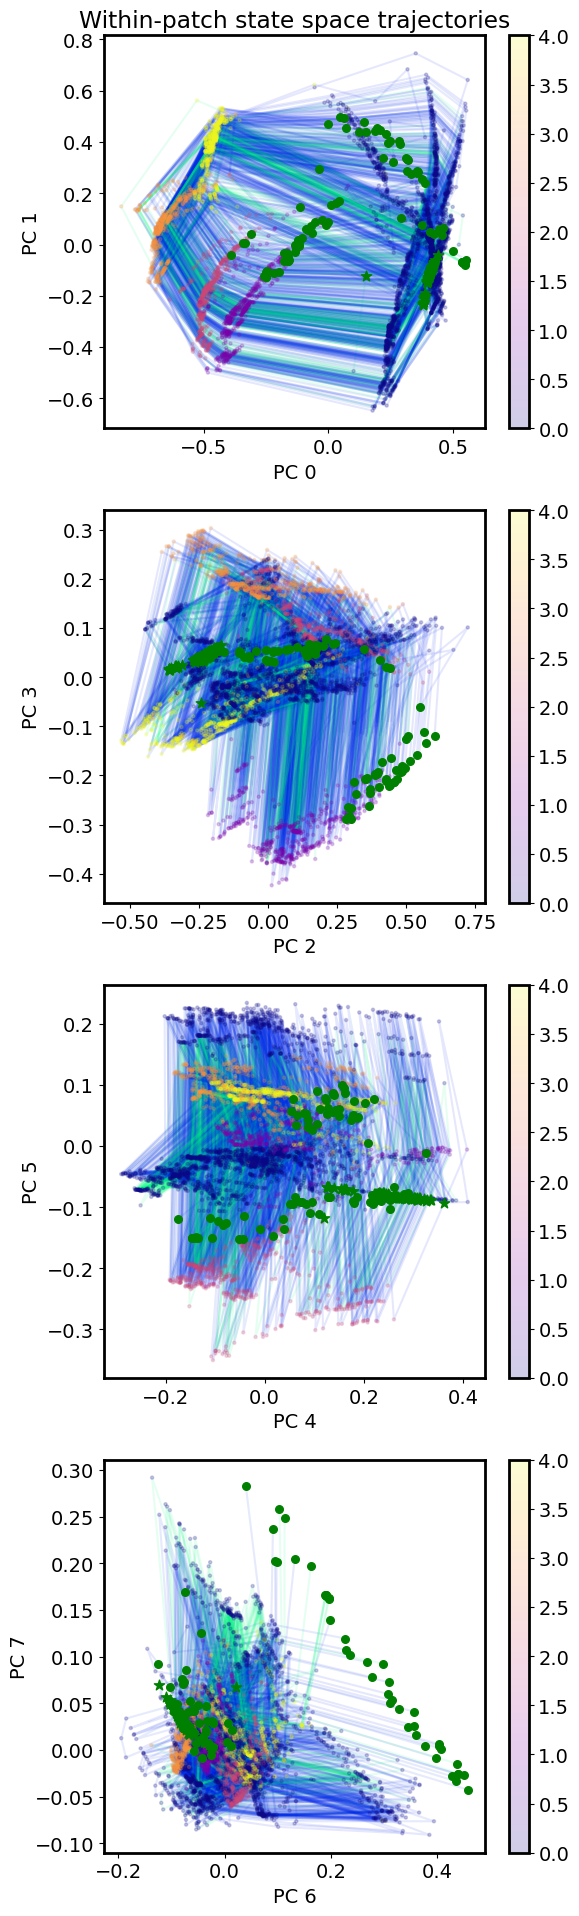

In [63]:
env_idx = 9

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')
session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])

norm = mpl.colors.Normalize(vmin=0, vmax=30)

for k in np.arange(0, 8, 2):
    pc_a = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k]
    pc_b = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1]

    # cbar = axs[int(k/2)].scatter(
    #     pc_a,
    #     pc_b,
    #     s=1,
    #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
    #     # vmax=2,
    #     alpha=0.2
    # )
    
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_reward_param = session_data['patch_reward_param'][patch_traj_indices][0]

        colored_line(
            pc_a[patch_traj_indices],
            pc_b[patch_traj_indices],
            patch_reward_param * np.ones(len(pc_b[patch_traj_indices])),
            axs[int(k/2)],
            alpha=0.1,
            cmap='winter',
            zorder=-2,
            norm=norm,
        )

        cbar = axs[int(k/2)].scatter(
            pc_a[patch_traj_indices],
            pc_b[patch_traj_indices],
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            c=session_data['dwell_time'][patch_traj_indices],
            cmap='plasma',
            s=5,
            zorder=-1,
            alpha=0.2,
        )

        axs[int(k/2)].scatter(
            pc_a[patch_traj_indices][0],
            pc_b[patch_traj_indices][0],
            marker='*',
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            color=c,
            s=60,
        )

        axs[int(k/2)].scatter(
            pc_a[patch_traj_indices][-1],
            pc_b[patch_traj_indices][-1],
            marker='o',
            # c=session_data['dwell_time'][patch_starts_and_ends[0]],
            # vmax=2,
            color=c,
            s=30,
        )
            
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Within-patch state space trajectories')

['00000.pkl']


Text(0.5, 1.0, 'Within-patch state space trajectories')

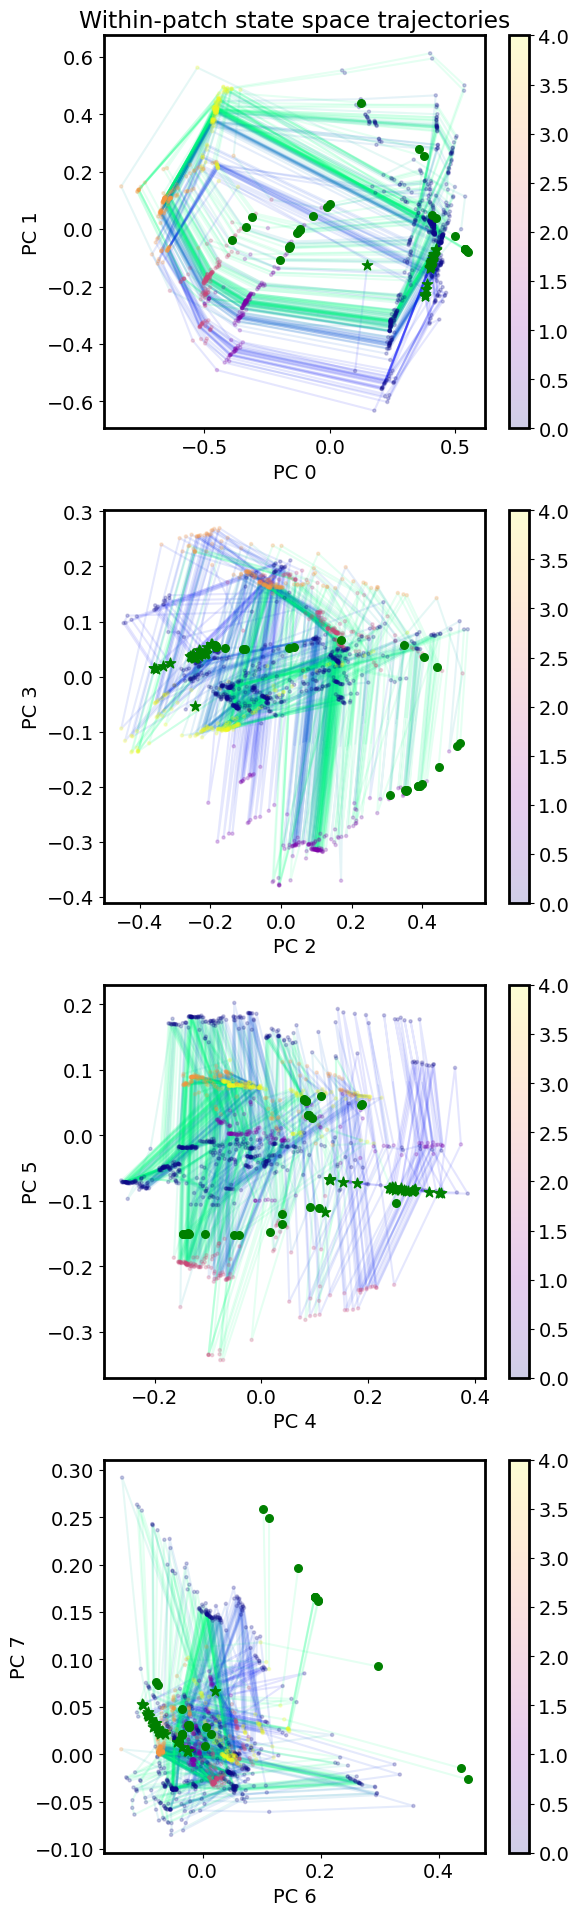

In [75]:
env_idx = 9

data = load_hidden_activity('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/hidden_activity/*.npy')
flattened_data = data.reshape(data.shape[0] * data.shape[1], data.shape[2], order='F')
session_data = parse_session('../data/rl_agent_outputs/load_and_run_model_2024-09-19_15_13_34_887835/state', env_idx)

pca = PCA()
pc_activities = pca.fit_transform(flattened_data)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 1.2
fig, axs = plt.subplots(4, 1, figsize=(5 * scale, 16 * scale))

patch_starts_and_ends = find_patch_trajectories(session_data['agent_in_patch'])

norm = mpl.colors.Normalize(vmin=0, vmax=30)

for k in np.arange(0, 8, 2):
    pc_a = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k]
    pc_b = pc_activities[data.shape[0] * env_idx:data.shape[0] * (env_idx + 1), k+1]

    # cbar = axs[int(k/2)].scatter(
    #     pc_a,
    #     pc_b,
    #     s=1,
    #     # c=session_data['dwell_time'][patch_starts_and_ends[0]],
    #     # vmax=2,
    #     alpha=0.2
    # )
    
    for traj_idx, patch_traj_indices in enumerate(patch_starts_and_ends):
        patch_reward_param = session_data['patch_reward_param'][patch_traj_indices][0]

        if patch_reward_param > 25:

            colored_line(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                np.arange(len(pc_b[patch_traj_indices])),
                axs[int(k/2)],
                alpha=0.1,
                cmap='winter',
                zorder=-2,
                norm=norm,
            )
    
            cbar = axs[int(k/2)].scatter(
                pc_a[patch_traj_indices],
                pc_b[patch_traj_indices],
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                c=session_data['dwell_time'][patch_traj_indices],
                cmap='plasma',
                s=5,
                zorder=-1,
                alpha=0.2,
            )
    
            axs[int(k/2)].scatter(
                pc_a[patch_traj_indices][0],
                pc_b[patch_traj_indices][0],
                marker='*',
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                color=c,
                s=60,
            )
    
            axs[int(k/2)].scatter(
                pc_a[patch_traj_indices][-1],
                pc_b[patch_traj_indices][-1],
                marker='o',
                # c=session_data['dwell_time'][patch_starts_and_ends[0]],
                # vmax=2,
                color=c,
                s=30,
            )
            
    axs[int(k/2)].set_xlabel(f'PC {k}')
    axs[int(k/2)].set_ylabel(f'PC {k+1}')
    fig.colorbar(cbar)
fig.tight_layout()

axs[0].set_title('Within-patch state space trajectories')